
# 2.2-kW PMSM, diode bridge

This example simulates sensorless current-vector control of a 2.2-kW PMSM
drive, equipped with a diode bridge rectifier.


In [1]:
pip install motulator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.1 MB/s eta 0:00:00


In [2]:
from motulator.drive import model
import motulator.drive.control.sm as control
from motulator.drive.utils import (
    BaseValues, NominalValues, plot, plot_extra, SynchronousMachinePars)

Compute base values based on the nominal values (just for figures).



In [3]:
nom = NominalValues(U=370, I=4.3, f=75, P=2.2e3, tau=14)
base = BaseValues.from_nominal(nom, n_p=3)

Configure the system model.



In [4]:
# Machine model and mechanical subsystem
mdl_par = SynchronousMachinePars(
    n_p=3, R_s=3.6, L_d=.036, L_q=.051, psi_f=.545)
machine = model.SynchronousMachine(mdl_par)
mechanics = model.StiffMechanicalSystem(J=.015)

# Frequency converter with a diode bridge
converter = model.FrequencyConverter(C_dc=235e-6, L_dc=2e-3, U_g=400, f_g=50)
mdl = model.Drive(converter, machine, mechanics)

mdl.pwm = model.CarrierComparison()  # Enable the PWM model

Configure the control system.



In [5]:
par = mdl_par  # Assume accurate machine model parameter estimates
ref = control.CurrentReferenceCfg(par, nom_w_m=base.w, max_i_s=1.5*base.i)
ctrl = control.CurrentVectorControl(
    par, ref, J=.015, T_s=250e-6, sensorless=True)

Set the speed reference and the external load torque.



In [6]:
# Speed reference (electrical rad/s)
ctrl.ref.w_m = lambda t: (t > .2)*base.w

# External load torque
mdl.mechanics.tau_L = lambda t: (t > .6)*nom.tau

Create the simulation object and simulate it.



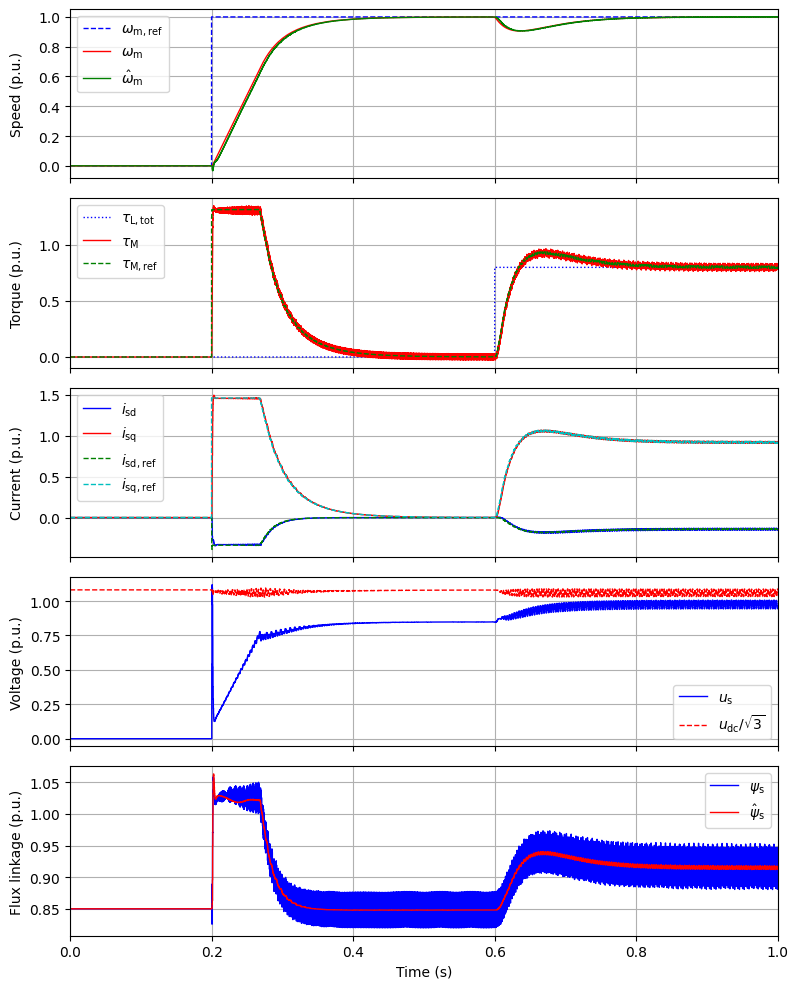

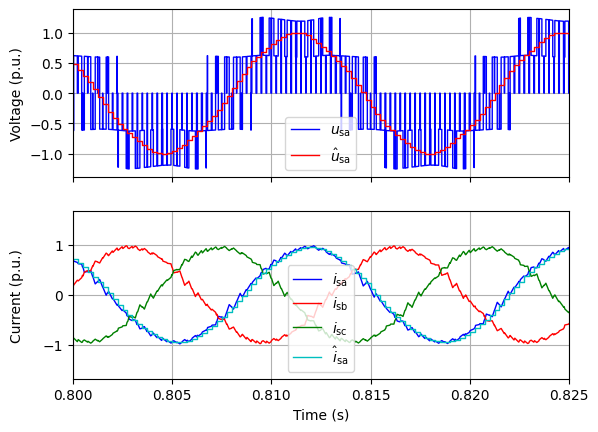

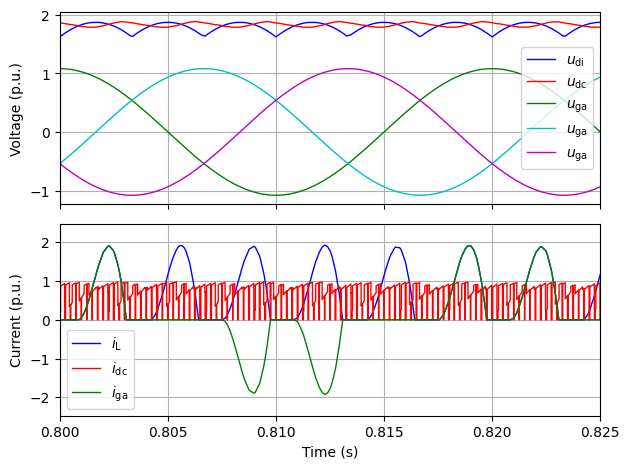

In [7]:
# Simulate the system
sim = model.Simulation(mdl, ctrl)
sim.simulate(t_stop=1)

# Plot results in per-unit values
plot(sim, base)
plot_extra(sim, base, t_span=(.8, .825))